In [15]:
import cv2
import os
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pickle
import random

In [16]:
DATASET_PATH = r'../images-synth'

DATE_IMAGE_WIDTH = 320
DATE_IMAGE_HEIGHT = 80

SEGMENTED_OUTPUT_DIRECTORY = r'../segmented-images-synth-2'

PYTESSERACT_CONFIG = r'--psm 10 --oem 1 -c tessedit_char_whitelist=0123456789/.'
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [17]:
def preprocess_date_image(image):
    original_image = cv2.resize(image, (DATE_IMAGE_WIDTH, DATE_IMAGE_HEIGHT))
    image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    _, th3 = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    black_count = np.sum(th3 == 0)
    white_count = np.sum(th3 == 255)

    if black_count < white_count:
        image = cv2.bitwise_not(th3)
    else:
        image = th3
    
    return image, original_image

In [18]:
def segmentate_horizontal(image):
    vertical_pixel_count = np.sum(image == 255, axis=0)

    images = []
    current_x = 0
    is_character = False
    for index, count in enumerate(vertical_pixel_count):
        if count == 0:
            if is_character:
                # if index - current_x > 20:
                images.append(image[:, current_x:index])
                is_character = False
            current_x = index
        else:
            is_character = True
        
    return images


def segmentate_vertical(image):
    horizontal_pixel_count = np.sum(image == 255, axis=1)

    current_y = 0
    is_character = False
    for index, count in enumerate(horizontal_pixel_count):
        if count == 0:
            if is_character:
                image = image[current_y:index, :]
                break
            current_y = index
        else:
            is_character = True

    return image

def segment_image(image):
    images = segmentate_horizontal(image)
    
    images = [segmentate_vertical(image) for image in images]

    images = [cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0]) for image in images]
            
    return images

In [19]:
images = os.listdir(DATASET_PATH)

image_data = []

if not os.path.exists(SEGMENTED_OUTPUT_DIRECTORY):
    os.makedirs(SEGMENTED_OUTPUT_DIRECTORY)

if os.listdir(SEGMENTED_OUTPUT_DIRECTORY):
    for file in os.listdir(SEGMENTED_OUTPUT_DIRECTORY):
        os.remove(f'{SEGMENTED_OUTPUT_DIRECTORY}/{file}')


for index, image_name in enumerate(images):
    image_path = os.path.join(DATASET_PATH, image_name)
    
    original_image = cv2.imread(image_path)

    image, original_image = preprocess_date_image(original_image)

    segmented_images = segment_image(image)

    for segmented_image in segmented_images:
        character = pytesseract.image_to_string(
            segmented_image, 
            config=PYTESSERACT_CONFIG
        ).strip()
                
        if character == '' or character == ' ' or len(character) > 1:
            continue

        name = f'{SEGMENTED_OUTPUT_DIRECTORY}/{character}-{image_name}'
        resized_image = cv2.resize(segmented_image, (28, 28))
        cv2.imwrite(name, resized_image)
    

    print(f'{index + 1}/{len(images)} - {image_name}')

1/1001 - 00000.jpg
2/1001 - 00001.jpg
3/1001 - 00002.jpg
4/1001 - 00003.jpg
5/1001 - 00004.jpg
6/1001 - 00005.jpg
7/1001 - 00006.jpg
8/1001 - 00007.jpg
9/1001 - 00008.jpg
10/1001 - 00009.jpg
11/1001 - 00010.jpg
12/1001 - 00011.jpg
13/1001 - 00012.jpg
14/1001 - 00013.jpg
15/1001 - 00014.jpg
16/1001 - 00015.jpg
17/1001 - 00016.jpg
18/1001 - 00017.jpg
19/1001 - 00018.jpg
20/1001 - 00019.jpg
21/1001 - 00020.jpg
22/1001 - 00021.jpg
23/1001 - 00022.jpg
24/1001 - 00023.jpg
25/1001 - 00024.jpg
26/1001 - 00025.jpg
27/1001 - 00026.jpg
28/1001 - 00027.jpg
29/1001 - 00028.jpg
30/1001 - 00029.jpg
31/1001 - 00030.jpg
32/1001 - 00031.jpg
33/1001 - 00032.jpg
34/1001 - 00033.jpg
35/1001 - 00034.jpg
36/1001 - 00035.jpg
37/1001 - 00036.jpg
38/1001 - 00037.jpg
39/1001 - 00038.jpg
40/1001 - 00039.jpg
41/1001 - 00040.jpg
42/1001 - 00041.jpg
43/1001 - 00042.jpg
44/1001 - 00043.jpg
45/1001 - 00044.jpg
46/1001 - 00045.jpg
47/1001 - 00046.jpg
48/1001 - 00047.jpg
49/1001 - 00048.jpg
50/1001 - 00049.jpg
51/1001 -

In [20]:
SEGMENTED_DATASET_PATH = r'../segmented-images-synth-2'

MODEL_NAME = f'random-forest.pkl'

In [21]:
dataset = []

for image_name in os.listdir(SEGMENTED_DATASET_PATH):
    image_path = os.path.join(SEGMENTED_DATASET_PATH, image_name)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (28, 28))
    
    label = image_name.split('-')[0]

    dataset.append((image, label))

In [22]:
X = [image.flatten() for image, _ in dataset]
Y = [label for _, label in dataset]

classes = np.unique(Y)
Y = LabelEncoder().fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [24]:
Y_pred = model.predict(X_test)

In [25]:
accuracy = accuracy_score(Y_test, Y_pred)
matrix = confusion_matrix(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

In [26]:
print(f'Accuracy: {accuracy}')

Accuracy: 0.9119086460032626


<Axes: >

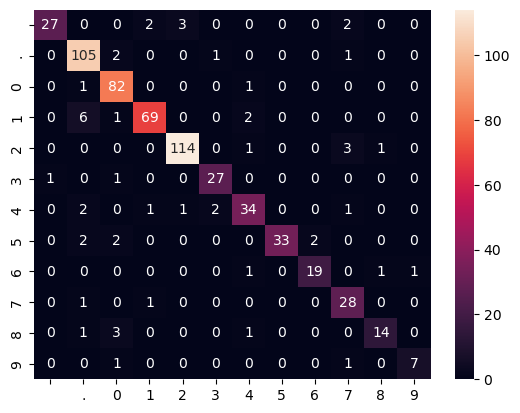

In [27]:
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

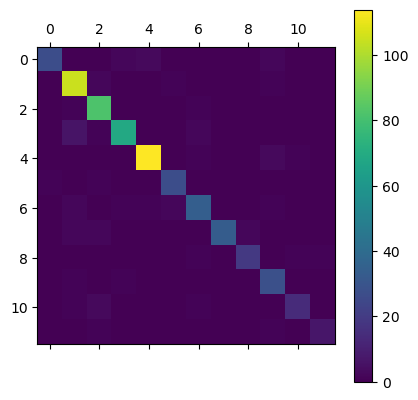

In [28]:
plt.matshow(matrix)
plt.colorbar()
plt.show()

In [29]:
print(f'Classification Report: {report}')

Classification Report:               precision    recall  f1-score   support

           0       0.96      0.79      0.87        34
           1       0.89      0.96      0.93       109
           2       0.89      0.98      0.93        84
           3       0.95      0.88      0.91        78
           4       0.97      0.96      0.96       119
           5       0.90      0.93      0.92        29
           6       0.85      0.83      0.84        41
           7       1.00      0.85      0.92        39
           8       0.90      0.86      0.88        22
           9       0.78      0.93      0.85        30
          10       0.88      0.74      0.80        19
          11       0.88      0.78      0.82         9

    accuracy                           0.91       613
   macro avg       0.90      0.87      0.89       613
weighted avg       0.92      0.91      0.91       613



In [30]:
with open(MODEL_NAME, 'wb') as file:
    pickle.dump(model, file)

In [31]:
images = os.listdir(DATASET_PATH)[500:1000]

image_data = []

predictions = []
for index, image_name in enumerate(images):
    image_path = os.path.join(DATASET_PATH, image_name)
    
    original_image = cv2.imread(image_path)

    image, original_image = preprocess_date_image(original_image)

    segmented_images = segment_image(image)

    segmented_images = [cv2.resize(image, (28, 28)) for image in segmented_images]    
    segmented_images = [image.flatten() for image in segmented_images]

    try:
        prediction = model.predict(segmented_images)
        
        prediction = "".join([classes[p] for p in prediction])
    
        predictions.append((image_name, prediction))
    except Exception as e:
        print(segmented_images)
    

[]
[]
[]
[]
[]
[]
[]
[]
[]


In [32]:
import json
ANNOTATIONS_PATH = '../annotations.json'

with open(ANNOTATIONS_PATH, 'r') as file:
    data = json.load(file)

def get_y_from_json(file: str) -> str:
    return " ".join(annotation['transcription'] for annotation in data[file]['ann'])

In [33]:

correct = 0
for name, label in predictions:
    real = get_y_from_json(name).replace(' ', '').replace('/', '').replace('.', '')
    label = label.replace(' ', '').replace('/', '').replace('.', '')
    # print(f'{name} - {label} - {real}')
    
    if label == real:
        correct += 1
        
print(f'Correct: {correct}/{len(predictions)}')
print(f'Accuracy: {correct / len(predictions)}')

Correct: 193/491
Accuracy: 0.39307535641547864
